## **Simulation**
***


1. [Overview](#Overview)
1. [Acquire and explore data](#Acquire-and-explore-data)
1. [Simulate minimum temperature](#Simulate-minimum-temperature)
1. [Simulate maximum temperature](#Simulate-maximum-temperature)


### Overview

This notebook simulates one year of data at Cork Airport, Ireland. About fifty years of historical weather data from hundreds of weather stations around Ireland is available from the Met Eireann website [1]. To perform this simulation, a subset of the data available from Cork Airport is used to identify the features of a few of the variables from that data.

In [290]:
# imports
# numerical computing
import numpy as np
# pseudo-random number generation
from numpy.random import default_rng
# data management and manipulation
import pandas as pd 
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [291]:
# initialise the random number generator
# seeded for reproducibility
rng = default_rng(99)

### Acquire and explore data

First the data is downloaded. The Met Eireann website provides it as a csv file and some text files zipped together. This was done manually, with the downloaded archive unzipped to the `data/` directory. The entire dataset from 1962 to present was downloaded, and is present in the `data/` folder, but only four variables tracked over the course of one year will be used her. The four variables used will be:
- Minimum temperature (°C)
- Maximum temperature (°C)
- Precipitation Amount (mm)
- Sunshine duration (hours)

There is one record for each day and the date will be used to index the DataFrame. The dataset will be subset to include all records from 01-12-2020 to 30-11-2021; 365 records. For convenience, a month column will be added.

The purpose of this dataset is to examine the nature of each meteorological phenomenon with a view to creating random data representing one year of the same phenomena that is indistinguishable from the real data.

Next, the data is loaded into a DataFrame:

In [292]:
# Read csv to dataframe
df = pd.read_csv('data/source/dly3904.csv', header=21)
# subset the columns of interest
df = df[['date', 'maxtp', 'mintp', 'rain', 'sun']]
# cast date column as date type
df['date'] = pd.to_datetime(df['date'])
# subset to one year of data
one_year = (df['date'] >= '2020-12-1') & (df['date'] <= '2021-11-30')
df = df.loc[one_year]
# Set date as index
df.set_index('date', inplace=True)
# cast sun and ran as floats
df = df.astype({'rain': 'float64', 'sun': 'float64'})
# add a month column
df['month'] = pd.DatetimeIndex(df.index).month_name()

In [293]:
# Dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-12-01 to 2021-11-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   maxtp   365 non-null    float64
 1   mintp   365 non-null    float64
 2   rain    365 non-null    float64
 3   sun     365 non-null    float64
 4   month   365 non-null    object 
dtypes: float64(4), object(1)
memory usage: 17.1+ KB


In [294]:
# Take a look at the data
df.head()

,maxtp,mintp,rain,sun,month
date,,,,,
2020-12-01,12.0,7.7,0.0,2.0,December
2020-12-02,9.0,4.0,0.1,1.0,December
2020-12-03,5.3,0.1,1.9,3.0,December
2020-12-04,6.2,0.8,1.5,4.8,December
2020-12-05,6.6,4.7,0.9,0.9,December


In [295]:
# view some descriptive statistics
np.round(df.describe(), 2)

,maxtp,mintp,rain,sun
count,365.00,365.00,365.00,365.00
mean,13.10,7.00,3.51,4.25
std,4.97,4.47,6.21,4.03
min,1.90,-2.70,0.00,0.00
25%,9.70,3.50,0.00,0.40
50%,12.80,6.70,0.60,3.20
75%,16.80,11.00,4.60,7.00
max,25.70,17.40,50.10,15.20


Overall, the distributions of the data are difficult to pin down visually. It seems likely that a stepwise simulation might be more appropriate than a random distribution.

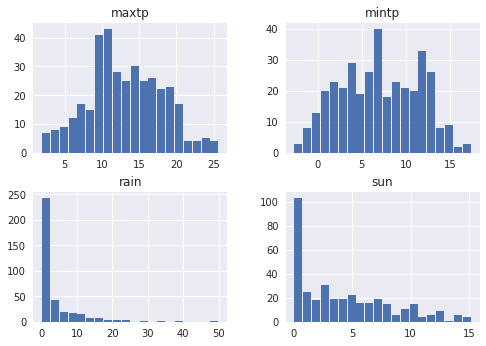

In [296]:
# Overall distribution of each variable
with plt.style.context('seaborn'):
    df.drop('month', axis=1).hist(rwidth=0.9, bins=20)

There's an extremely strong correlation between minimum and maximum temperature and weaker ones between rainfall and sunshine duration, and between maximum temperature and sunshine duration. There's no real correlation between rainfall and temperature or between sun and minimum temperature.

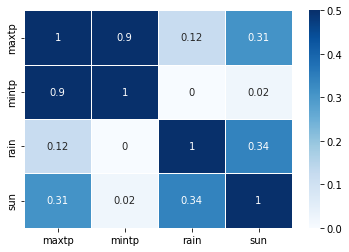

In [297]:
# Examine correlations between variables
corr = df.corr()
sns.heatmap(abs(corr.round(2)), annot=True, linewidths=0.5, cmap='Blues', vmax=0.5)
plt.show()

Looking at temperature first. As noted above there is an unsurprisingly high correlation between the minimum and maximum temperatures, which track one another closely throughout the year. Also unsurprisingly, they are both higher and further apart in the summer months. There is an upward trend from January until mid-July, and a downward trend from september until January.

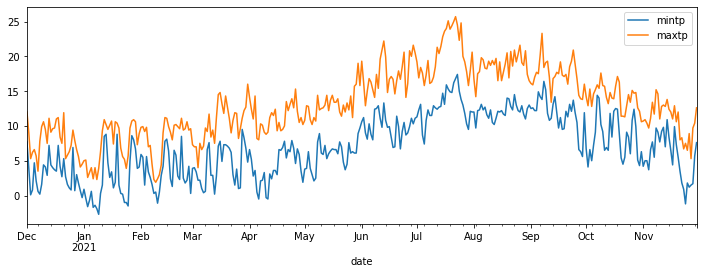

In [298]:
# Plot min and max temperatures
df[['mintp', 'maxtp']].plot(figsize=(12, 4));

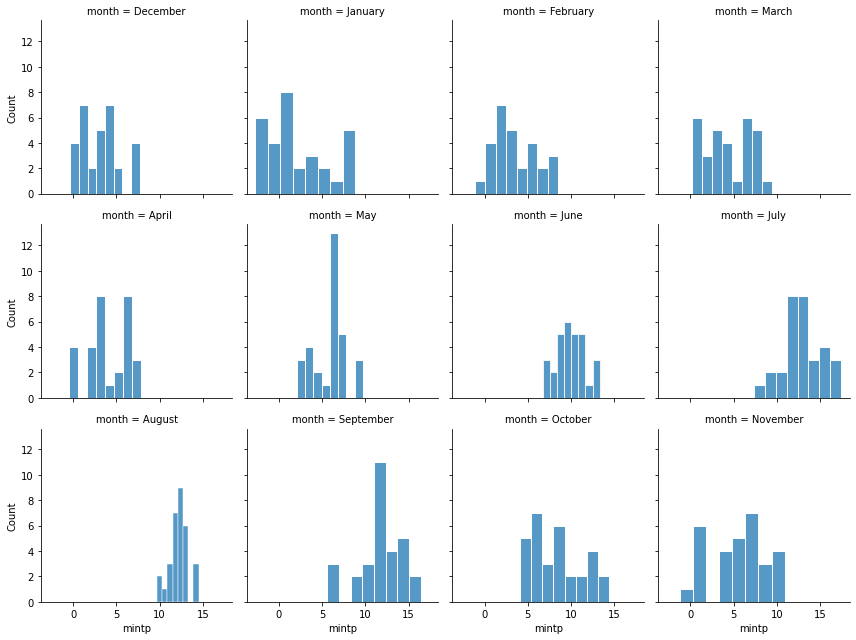

In [299]:
# Minimum temperature histograms for each month
g = sns.FacetGrid(df, col="month", col_wrap=4)
g.map(sns.histplot, "mintp", edgecolor='white', bins=8);

### Simulate minimum temperature
Below the values on which the temperature generator will be based are defined. First, a column is created, `mintpupdown`, which, for each day, holds the difference between the minimum temperature on that day and the minimum temperature on the previous day. Then, a new DataFrame is created , `df_ud`, which holds the counts of the number of days in each month that the minimum temperature rose and the number of days that it fell.

In [300]:
# Create up-down column in dataframe
df['mintpupdown']=df['mintp'].diff()
np.sum(df['mintpupdown'] < 0)

# Pandas DataFrame containing months and counts of days where the temp rose or fell
df_ud = pd.DataFrame()
df_ud['down'] = df[df['mintpupdown'] < 0].groupby('month').count()['mintpupdown']
df_ud['up'] = df[df['mintpupdown'] > 0].groupby('month').count()['mintpupdown']

# Look at df_ud contents
df_ud.head()

,down,up
month,,
April,16,13
August,17,13
December,21,9
February,16,12
January,16,14


A dictionary is created with months as keys and each value being a list of the same length as the number of days in the month. The list holds a series of '1's the length of which is equal to the count of the number of days in that month that the temperature rose in the real data, and a series of '-1's the length of which is equal to the count of the number of days in that month that the temperature fell in the real data. If there are any empty slots remaining, they are filled with '0's. Each list is then shuffled so that we now have a list of for each month that can be consulted to see if the temperature should rise, fall, or remain the same on that day. The list is random but the proprotion of rises to falls is the same as it is in the real data.

In [301]:
# dict, keyed by month containing an up or down value for each day
updown = {}
for month in df['month'].unique():
    # Get num days in current month
    days = df[df['month'] == month]['month'].count()
    # assemble list of up or down values
    up = [1] * df_ud.loc[month]['up']
    down = [-1] * df_ud.loc[month]['down']
    stay = [0] * (days - (len(up) + len(down)))
    updown[month] = up + down + stay
    #shuffle the list
    rng.shuffle(updown[month])

Finally, a list is intiailised that will hold the new simulated temperature data. The first value is a simple random number within the range allowable for the month. After that, each day's minimum temperature is based on that of the previous day. It is calculated as follows:
1. The direction of change is selected. The rules are:
    - If the previous days minimum temperature is less than or equal to the minimum allowable temperature for that time period (currently month), then the direction of change will be positive.
    - If the previous days temperature is greater than or equal to the maximum allowable temperature for that time period (currently month), then the direction of change will be negative.
    - Otherwise, the direction of change will be taken from that day's entry in the `updown` dictionary. Recall that the values in that dictionary, while random, follow an identical distribution to the real monthly rises and falls.

1. The magnitude of change is calculated:
    - If the direction of change is positive, then the magnitude is a float drawn from a uniform distribution between 0 and the previous day's temperature subtracted from the maximum allowable temperature for the current month.
    - If the direction of change is negative, then the magnitude is a float drawn from a uniform distribution between 0 and the minimum allowable temperature for the current month subtracted from the previous day's temperature. The result is then negated as it is a negative change.
    - Otherwise there should be no change and the magnitude is set to zero.
    
1. Finally, the magnitude is added to the previous day's temperature to get the new simulated temperature.

This is repeated for every day of the year, with the minimum and maximum allowable vlaues updating each month, based on the monthlu minimums and maximums in the real data. The list of simulated temperature is then added to the real data DataFrame as `sim_mintp`.

In [302]:
months = df['month'].unique()
vals = []
for month in months:
    # number of days in current month
    days = df[df['month'] == month]['month'].count()
    # Get the mins and maxes for the current month
    min = df[df['month'] == month]['mintp'].min()
    max = df[df['month'] == month]['mintp'].max()

    # Pick the first day's value at random
    if not vals:
        vals.append(rng.uniform(min, max))

    for i in range(days):
        prev_day = vals[-1]
        # Set temperature change direction for current day
        temp_dir = 0
        if prev_day <= min:
            temp_dir = 1
        elif prev_day >= max:
            temp_dir = -1
        else:
            temp_dir = updown[month][i]

        # Set temperature change 
        if temp_dir ==1:
            temp_mag = rng.uniform(0, max - prev_day) 
        elif temp_dir == -1:
            temp_mag = -rng.uniform(0, prev_day - min)
        else:
            temp_mag = 0

        # Set current day's value
        vals.append(prev_day + temp_mag)
        

len(vals)
    
# Add simulated temperature data to dataframe
df['sim_mintp'] = vals[1:]



[(-5.0, 27.0)]

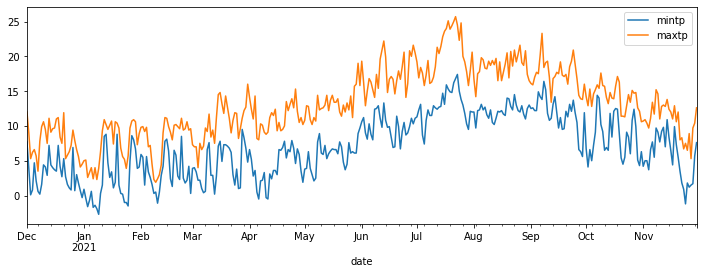

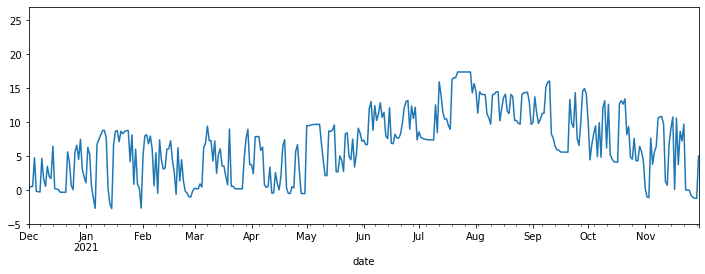

In [303]:
# Plot min and max temperatures
df[['mintp', 'maxtp']].plot(figsize=(12, 4));
plt.figure()
ax = df['sim_mintp'].plot(figsize=(12, 4));
ax.set(ylim=(-5, 27))


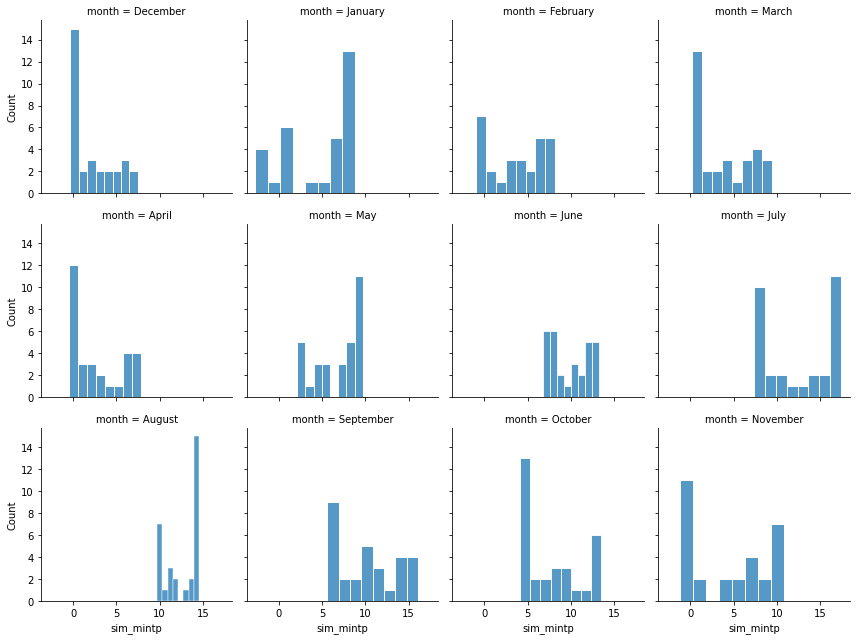

In [304]:
# Simulated minimum temperature histograms for each month
g = sns.FacetGrid(df, col="month", col_wrap=4)
g.map(sns.histplot, "sim_mintp", edgecolor='white', bins=8);

### Simulate maximum temperature



Because maximum temperature is so highly correlated to minimum temperature it can't be generated independently. It is clear from the plots above that there are two elements to their correlation. First, they tend to change in the same direction on a day to day basis. In addition to being clear visually above, this will be shown numerically below. Secondly, the minimum and maximum temperatures tend to be further apart in the summer months and closer together the rest of the year.

First we assess how often the maximum temperature moves in the same direction as the minimum temperature.

In [305]:
# Create max temp up-down column in dataframe
df['maxtp_updown']=df['maxtp'].diff()
# Create column with true if max temp change direction was same as min temp change direction
df['maxtp_samedir'] = np.sign(df['maxtp_updown']) == np.sign(df['mintpupdown'])

# Add a column to the up-down dataframe with counts of days where
# the temp change was the same for both max and min temperatures
df_ud['same_dir'] = df[df['maxtp_samedir'] == True].groupby('month').count()['maxtp_samedir']
df_ud['diff_dir'] = df[df['maxtp_samedir'] == False].groupby('month').count()['maxtp_samedir']


# Look at df_ud contents
df_ud

,down,up,same_dir,diff_dir
month,,,,
April,16,13,17,13
August,17,13,14,17
December,21,9,21,10
February,16,12,19,9
January,16,14,23,8
July,16,14,19,12
June,14,16,18,12
March,16,12,16,15
May,13,16,14,17


Then we calculate each day's minimum-maximum temperature disparity and select the largest and smallest of those values per month, as the limits to enforce on the simulated dataset. 

In [306]:
# Create a new column holding the absolute difference 
# between the min and max temperatures
df['minmax_temp_diff'] = np.abs(df['maxtp'] - df['mintp'])

1. First value only has magnitude.

1. for each month, for each day, get sim_mintemp. get sim_mintemp direction. calculate change magnitude. calculate maxtemp by applyiing change direction and magnitude to previous day's temperature.

In [307]:
# Update the updown lists with rise and fall instructions for the simulated max temp
for month in df['month'].unique():
    # Get num days in current month
    days = df[df['month'] == month]['month'].count()
    # assemble list of same or diff direction values
    same = [1] * df_ud.loc[month]['same_dir']
    diff = [-1] * df_ud.loc[month]['diff_dir']
    change = same + diff
    # shuffle the list
    rng.shuffle(change)
    # multiplying updown list by the change list
    # produces the new updown list
    updown[month] = np.multiply(updown[month], change)

All of the data needed to simulate the daily maximum temperature is now available. The procedure to generate it is as follows:
1. 

In [338]:
vals = []
for month in months:
    # number of days in current month
    days = df[df['month'] == month]['month'].count()
    # Get the mins and maxes for the current month
    min_diff = df[df['month'] == month]['minmax_temp_diff'].min()
    max_diff = df[df['month'] == month]['minmax_temp_diff'].max()

    # min = df[df['month'] == month]['mintp'].min()
    # max = df[df['month'] == month]['mintp'].max()

    # Pick the first day's value at random
    if not vals:
        vals.append(rng.uniform(min, max))

    for i in range(days):

        mintp = df[df['month'] == month]['mintp'].iloc[i]
        min = mintp + min_diff
        max = mintp + max_diff

        if not vals:
            vals.append(rng.uniform(min, max))

        prev_day = vals[-1]
        # Set temperature change direction for current day
        temp_dir = 0
        if prev_day <= min:
            temp_dir = 1
        elif prev_day >= max:
            temp_dir = -1
        else:
            temp_dir = updown[month][i]

        # Set temperature change 
        if temp_dir == 1:
            temp_mag = rng.uniform(0, max - prev_day) 
        elif temp_dir == -1:
            temp_mag = -rng.uniform(0, prev_day - min)
        else:
            temp_mag = 0

        # Set current day's value
        vals.append(prev_day + temp_mag)
        


    
# Add simulated temperature data to dataframe
df['sim_maxtp'] = vals[1:]

[(-5.0, 27.0)]

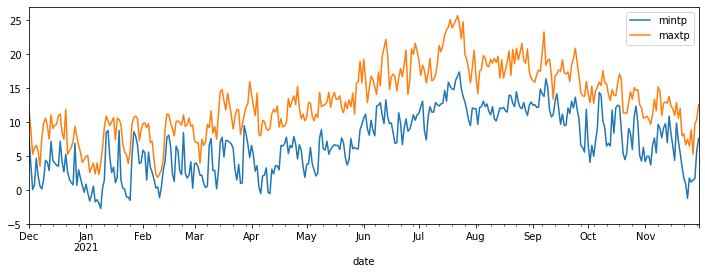

<Figure size 432x288 with 0 Axes>

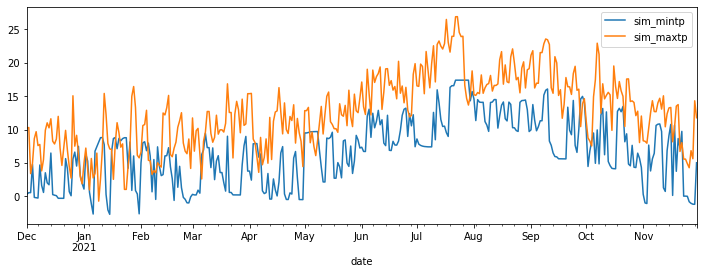

In [339]:
# Plot min and max temperatures
ax1 = df[['mintp', 'maxtp']].plot(figsize=(12, 4));
ax1.set(ylim=(-5, 27))
plt.figure()
ax2 = df[['sim_mintp', 'sim_maxtp']].plot(figsize=(12, 4));
ax.set(ylim=(-5, 27))

### Simulate rainfall


In [313]:
df['rain']

date
2020-12-01    0.0
2020-12-02    0.1
2020-12-03    1.9
2020-12-04    1.5
2020-12-05    0.9
             ... 
2021-11-26    1.5
2021-11-27    0.0
2021-11-28    1.1
2021-11-29    0.7
2021-11-30    6.3
Name: rain, Length: 365, dtype: float64


max temp:

count number of days per month that max temp went same direction as min temp

find distribution of daily difference between max and min temp

calculate max temp differences and directions

General Steps
1. Identify variables and give them types
1. Identify distribution, mean, median, standard deviation for each variable
1. Identify Relationships between variables

Specific Steps
The max temp, min temp, rainfall (mm), and the sun (hours) will be simulated for every day for one year. The granularity of the simulation will be one month. For the moment this will not be a moving window simply a calendar month.

The variables will all be floats, except for the month which will be a string.

The strategy will be to estimate the distribution, etc for each variable for each month and then to adjust the relationships between variables as necessary.

### References

[1] Met Eireann &mdash; Irish Meteorological Service, Historical Data [online]. Available from https://www.met.ie/climate/available-data/historical-data

